<a href="https://colab.research.google.com/github/alexanderimanicowenrivers/Deeplearning.ai/blob/master/MNIST_Prune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro 

In this colab document we will explore how to create and prune a basic model in tensorflow.


# Imports & utils

In [1]:
from __future__ import print_function
import keras
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow.contrib.eager as tfe
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
# Plot learning curves of experiments
def plot_learning_curves(results):
  # Generate figure.
  fig, axes = plt.subplots(1, 3, figsize=(22,12))
  st = fig.suptitle(
      "Learning Curves for all Tasks and Hyper-parameter settings",
      fontsize="x-large")
  # Plot all learning curves.
  for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
    # Plot.
    xs = [x * log_period_samples for x in range(1, len(train_accuracy)+1)]
    axes[j].plot(xs, train_accuracy, label='train_accuracy')
    axes[j].plot(xs, test_accuracy, label='val_accuracy')
    # Prettify individual plots.
    axes[j].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    axes[j].set_xlabel('Number of samples processed')
    axes[j].set_ylabel('Epochs: {}, Learning rate: {}.  Accuracy'.format(*setting))
    axes[j].set_title('Settings {}'.format(j + 1))
    axes[j].legend()
  # Prettify overall figure.
  plt.tight_layout()
  st.set_y(0.95)
  fig.subplots_adjust(top=0.91)
  plt.show()

# Generate summary table of results.
def plot_summary_table(experiment_data):
  # Fill Data.
  cell_text = []
  rows = []
  columns = ['Setting 1', 'Setting 2', 'Setting 3']
  for i, results in enumerate(experiment_data):
    rows.append('Model {}'.format(i + 1))
    cell_text.append([])
    for j, (setting, train_accuracy, test_accuracy) in enumerate(results):
      cell_text[i].append(test_accuracy[-1])
  # Generate Table.
  fig=plt.figure(frameon=False)
  ax = plt.gca()
  the_table = ax.table(
      cellText=cell_text,
      rowLabels=rows,
      colLabels=columns,
      loc='center')
  the_table.scale(1, 4)
  # Prettify.
  ax.patch.set_facecolor('None')
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

# Data loader

In [0]:
# Global variables.
log_period_samples = 2000
batch_size = 1000

In [0]:
def get_data():
    return input_data.read_data_sets("MNIST_data/", one_hot=True)

In [5]:
  mnist=get_data()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
# Store results of runs with different configurations in a dictionary.
# Use a tuple (num_epochs, learning_rate) as keys, and a tuple (training_accuracy, testing_accuracy)
settings = [(1, 0.01),(1, 0.005),(1, 0.001)]

# Model

In [0]:
weight_default_name='weight'
bias_default_name='bias'

def get_placeholders():
  x = tf.placeholder(tf.float32, [None, 784])
  y_ = tf.placeholder(tf.float32, [None, 10])
  return x, y_

def _weight_variable(
        shape,
        initializer=None,
        name=None,
        layer_no=0,):
    """
    Returns a weight variable with a given shape.
    :param initializer: TensorFlow initializer. Default Xavier.
    :param layer: Variable layer number.
    :param shape: var shape.
    """
    if name==weight_default_name: 
      name=weight_default_name+'_'+str(layer_no)
      
    if initializer is None:
        initializer = tf.contrib.layers.xavier_initializer()

    var = tf.get_variable(name, shape, initializer=initializer)
    return var
  
def _bias_variable(
        shape,
        initializer=None,
        layer_no=0,
):
    """
    Returns a bias variable with a given shape.
    :param initializer: TensorFlow initializer. Default zero.
    :param layer_no: Variable layer number.
    :param shape: Variable shape.
    """
    name=bias_default_name+'_'+str(layer_no)
    if initializer is None:
        initializer = tf.constant_initializer(0.)

    return _weight_variable(shape,
                            initializer=initializer,
                            name=name)
  
  
def affine(
        inp,
        units,
        bias=True,
        W_initializer=None,
        b_initializer=None,
        W_name=weight_default_name,
        bias_name=bias_default_name,
        layer_no=0
):
    """ Creates an affine layer.
    :param inp: Input tensor.
    :param units: Number of units.
    :param bias: Include bias term.
    :param W_initializer: Initializer for the multiplicative weight.
    :param b_initializer: Initializer for the bias term.
    :param W_name: Name of the weight.
    :param bias_name: Name of the bias.
    :return: Tensor defined as input.dot(weight) + bias.
    """
    input_size = inp.shape[-1]
    W = _weight_variable([input_size, units],
                         initializer=W_initializer,
                         name=W_name,layer_no=layer_no)

    output = tf.matmul(inp, W)

    if bias:
        b = _bias_variable((units,),
                           initializer=b_initializer,
                           layer_no=layer_no)

        output=tf.add(output, b)

    return output
  
def mlp(inputs,
        layer_sizes,
        nonlinearity=tf.nn.relu,
        output_nonlinearity=None,
        W_initializer=None,
        b_initializer=None):
    """
    Creates a multi-layer perceptron with given hidden sizes. A nonlinearity
    is applied after every hidden layer.
    
    output shape: N x (number of output units)
    :param inputs: List of input tensors.
    :param layer_sizes: List of layers sizes, including output layer size.
    :param nonlinearity: Hidden layer nonlinearity.
    :param output_nonlinearity: Output layer nonlinearity.
    :param W_initializer: Weight initializer.
    :param b_initializer: Bias initializer.
    :return:
    """
    if layer_sizes[-1] is None:
        layer_sizes = list(layer_sizes)
        layer_sizes[-1] = 1

    # Take care of the input layer separately to make use of broadcasting in
    # a case of several input tensors.
    layer = affine(
    inp=inputs,
    units=layer_sizes[0],
    bias=True,
    W_initializer=W_initializer,
    b_initializer=b_initializer
    )

    layer = nonlinearity(layer)

    for i_layer, size in enumerate(layer_sizes[1:], 1):

      layer = affine(layer, size,
                     W_initializer=W_initializer,
                     b_initializer=b_initializer,
                    layer_no=i_layer)
      if i_layer < len(layer_sizes) - 1:
          layer = nonlinearity(layer)

    return layer
  
def get_graph(layers):
  x, y_ = get_placeholders()
  linear=mlp(x,layers)
  loss=tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits=linear,labels=y_))
  opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
  correct_prediction = tf.equal(tf.argmax(linear,1), tf.argmax(y_,1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
  
  return x, y_,linear,loss,opt,correct_prediction,accuracy

# Training

In [33]:
experiments_task1 = []
print('Training Model 1')
layers=[1000, 1000, 500, 200,10]
# Train Model 1 with the different hyper-parameter settings.
for (num_epochs, learning_rate) in settings:

  # Reset graph, recreate placeholders and dataset.
  tf.reset_default_graph()
  mnist = get_data()
  eval_mnist = get_data()

  #####################################################
  # Define model, loss, update and evaluation metric. #
  #####################################################
  x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
  # Train.
  i, train_accuracy, test_accuracy = 0, [], []
  log_period_updates = int(log_period_samples / batch_size)
  saver = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    while mnist.train.epochs_completed < num_epochs:
      
      # Update.
      i += 1
      batch_xs, batch_ys = mnist.train.next_batch(batch_size)
      
      #################
      # Training step #
      #################
      feed_dict={x:batch_xs,y_:batch_ys}
      _=sess.run([opt],feed_dict=feed_dict)
      
      # Periodically evaluate.
      if i % log_period_updates == 0:
        
        #####################################
        # Compute and store train accuracy. #
        #####################################
        
        batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
        
        feed_dict={x:batch_xs,y_:batch_ys}
        acc=sess.run([accuracy],feed_dict)
        print(f'Accuracy {acc} at iteration {i}')

        train_accuracy.append(acc[0])
        #####################################
        # Compute and store test accuracy.  #
        #####################################

        feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
        acc=sess.run([accuracy],feed_dict)
        test_accuracy.append(acc[0])
        print(f'Validation Accuracy {acc}')
    save_path = saver.save(sess, "./model.ckpt")
    experiments_task1.append(
        ((num_epochs, learning_rate), train_accuracy, test_accuracy))

Training Model 1
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Accuracy [0.104727276] at iteration 2
Validation Accuracy [0.1037]
Accuracy [0.19909091] at iteration 4
Validation Accuracy [0.1943]
Accuracy [0.162] at iteration 6
Validation Accuracy [0.1638]
Accuracy [0.32463637] at iteration 8
Validation Accuracy [0.3283]
Accuracy [0.35181817] at iteration 10
Validation Accuracy [0.3565]
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/tra

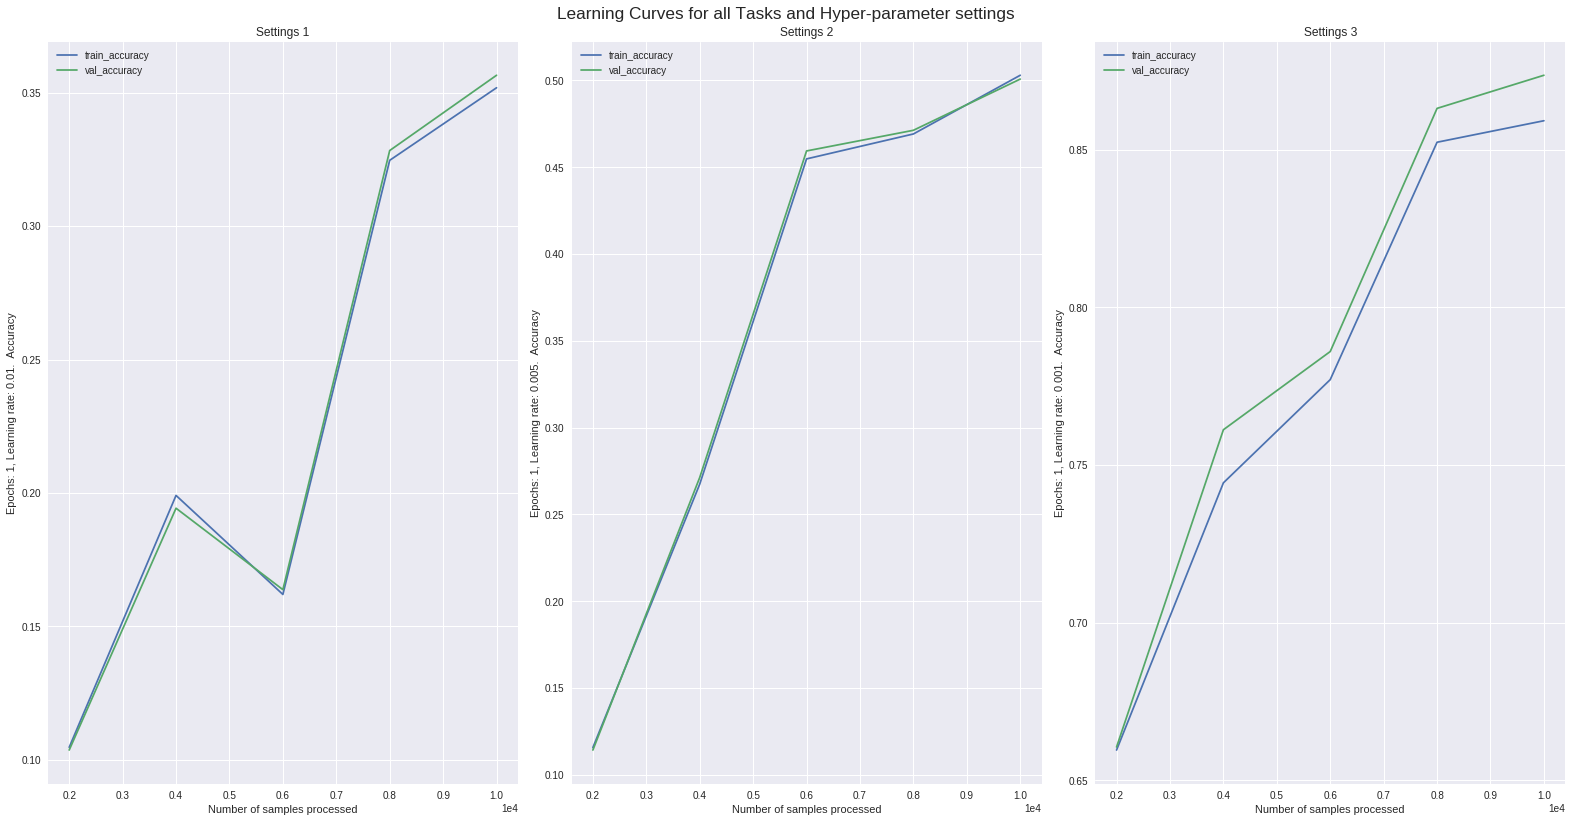

In [54]:
plot_learning_curves(experiments_task1)

## Restore test

In [55]:
tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)
saver = tf.train.Saver()

with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "./model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  batch_xs, batch_ys = mnist.train.next_batch((int(mnist.train.labels.shape[0]/5)))
  feed_dict={x:batch_xs,y_:batch_ys}
  acc=sess.run([accuracy],feed_dict)
  print(f'Accuracy {acc} at iteration {i}')
  total_parameters = 0
  print(f'{tf.trainable_variables()}')
  for variable in tf.trainable_variables():
      # shape is an array of tf.Dimension
      shape = variable.get_shape()
      variable_parameters = 1
      for dim in shape:
          variable_parameters *= dim.value
      total_parameters += variable_parameters
  print("total parameters",total_parameters)

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
Accuracy [0.8617273] at iteration 10
[<tf.Variable 'weight_0:0' shape=(784, 1000) dtype=float32_ref>, <tf.Variable 'bias_0:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'weight_1:0' shape=(1000, 1000) dtype=float32_ref>, <tf.Variable 'bias_1:0' shape=(1000,) dtype=float32_ref>, <tf.Variable 'weight_2:0' shape=(1000, 500) dtype=float32_ref>, <tf.Variable 'bias_2:0' shape=(500,) dtype=float32_ref>, <tf.Variable 'weight_3:0' shape=(500, 200) dtype=float32_ref>, <tf.Variable 'bias_3:0' shape=(200,) dtype=float32_ref>, <tf.Variable 'weight_4:0' shape=(200, 10) dtype=float32_ref>, <tf.Variable 'bias_4:0' shape=(10,) dtype=float32_ref>]
total parameters 2388710


# Pruning

In [0]:
k=[0, 25, 50, 60, 70, 80, 90, 95, 97, 99]
type_prunes=['unit','weight']

#prune with lowest l1 norm sum 

In [0]:

tf.reset_default_graph()
x, y_,linear,loss,opt,correct_prediction,accuracy=get_graph(layers)

saver = tf.train.Saver()
type_prune='weight'

print(total_parameters, "Total parameters to prune")
accs=[]
params=[]
with tf.Session() as sess:
  
  for type_prune in type_prunes:
    params_pruned=0.
    param_prune_count=[]
    acc_list=[]

  # Restore variables from disk.
    saver.restore(sess, "./model.ckpt")
    print("Model restored.")
    # Check the values of the variables
    all_vars = tf.trainable_variables()
    feed_dict={x:eval_mnist.test.images,y_:eval_mnist.test.labels}
  
    if type_prune=='unit':
      axis_sum=0 #add on abs of bias's 
    else: 
      axis_sum=1

    while params_pruned<total_parameters:

      #Evaluate 
      acc=sess.run(accuracy,feed_dict)
      param_prune_count.append(params_pruned)
      acc_list.append(acc)
      print(params_pruned, "paramns pruned")
      #Prune 
      var_mag=np.array([])
      layer_sizes=[]
      var_sizes=[]
      for var_num,variable in enumerate(all_vars):
        if 'weight' in variable.name and str(len(layers)-1) not in variable.name: #leave out last layer 
          var_sizes.append(variable.shape)
          layer_sizes.append(variable.shape[1-axis_sum].value)
          if type_prune=='unit':
            unit_vals=tf.reduce_sum(tf.math.abs(variable),axis=axis_sum).eval()+tf.reduce_sum(tf.math.abs(all_vars[var_num+1]),axis=axis_sum).eval()
            var_mag=np.concatenate((var_mag,unit_vals),axis=0)
          else: 
            var_mag=np.concatenate((var_mag,tf.reduce_sum(tf.math.abs(variable),axis=axis_sum).eval()),axis=0)

      all_concat=np.reshape(np.array(var_mag),((-1,)))
      prune_indx=np.argmin(all_concat)

      cum_sum_ind=np.cumsum(layer_sizes)
      for idx,lens in enumerate(cum_sum_ind):
        if prune_indx<lens:
          prun_ind=lens-prune_indx
          if type_prune=='unit':

            mask=np.ones(var_sizes[idx])*1.0
            mask[:,idx]=0

            maskb=np.ones(var_sizes[idx][1])*1.0
            maskb[idx]=0


            w_ind=idx*2
            assign_op1=all_vars[w_ind].assign(all_vars[w_ind]*mask)
            assign_op2=all_vars[w_ind+1].assign(all_vars[w_ind+1]*maskb)
            assign_op=[assign_op1,assign_op2]

            params_pruned+=var_sizes[idx][0]+1

          else: 
            mask=np.ones(var_sizes[idx])*1.0
            mask[idx]=0
            w_ind=idx*2
            assign_op=all_vars[w_ind].assign(all_vars[w_ind]*mask)
            params_pruned+=var_sizes[idx][1]+1

      sess.run(assign_op)

      #Train 
      mnist.train._epochs_completed = 0
      mnist.train._index_in_epoch = 0
      while mnist.train.epochs_completed < num_epochs:
        # Update.
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)

        #################
        # Training step #
        #################
        feed_dict={x:batch_xs,y_:batch_ys}
        _=sess.run([opt],feed_dict=feed_dict)
    print(acc_list,"acc list")
    print(param_prune_count,"param_prune_count list")
    print(type_prune,"type_prune is")

    accs.append(acc_list)
    params.append(param_prune_count)

2388710 Total parameters to prune
INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
0.0 paramns pruned
501 paramns pruned
1002 paramns pruned
1503 paramns pruned
2004 paramns pruned


# Analysis